In [1]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch, os
from torch.utils.data import Dataset
from ipywidgets import interact 
import seaborn as sns
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import tensorflow as tf
import numpy as np

In [2]:
torch.__version__

'2.1.0+cpu'

# Loading Data

In [3]:
train_df, test_df = pd.read_csv('seed.csv'), pd.read_csv('test.csv')

In [5]:
train_df['label'].unique()

array(['wrong_amount_of_cash_received', 'fiat_currency_support',
       'pin_blocked', 'receiving_money', 'age_limit', 'compromised_card',
       'atm_support', 'virtual_card_not_working', 'pending_top_up',
       'passcode_forgotten', 'direct_debit_payment_not_recognised',
       'lost_or_stolen_phone', 'card_arrival', 'reverted_card_payment?',
       'change_pin', 'why_verify_identity', 'topping_up_by_card',
       'exchange_via_app', 'transfer_timing', 'card_linking',
       'cash_withdrawal_charge', 'card_delivery_estimate',
       'contactless_not_working', 'top_up_by_card_charge',
       'verify_top_up', 'beneficiary_not_allowed', 'pending_card_payment',
       'card_payment_wrong_exchange_rate', 'get_physical_card',
       'country_support', 'get_disposable_virtual_card', 'request_refund',
       'balance_not_updated_after_bank_transfer', 'exchange_rate',
       'verify_my_identity', 'unable_to_verify_identity',
       'edit_personal_details', 'top_up_failed', 'activate_my_card'

In [6]:
total_df = pd.concat([train_df,test_df],axis=0)

In [8]:
len(total_df.label.unique())

77

In [6]:
id_to_label = {id : label for id, label in enumerate(total_df.label.unique())}
label_to_id = {label : id  for id, label in enumerate(total_df.label.unique())}

In [6]:
train_df['label']= train_df['label'].map(label_to_id)
test_df['label'] = test_df['label'].map(label_to_id)

# Spliting Data into train_encodings, test_encodings

In [7]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=6000)

In [8]:
train_encodings = tokenizer(train_df['example'].to_list(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['example'].to_list(), truncation=True, padding=True)
train_labels = train_df.label.to_list()
test_labels = test_df.label.to_list()

In [9]:
train_df['label'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72], dtype=int64)

In [10]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(total_df['label'].unique()), id2label = id_to_label, label2id = label_to_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### TrainingArguments, Dataloader, Metrics are needed to construct this Fine-tune the model

In [11]:
training_args = TrainingArguments(
    output_dir='./BERTModel2',
    do_train=True,
    do_eval=True,
    num_train_epochs=3,  # Reduced number of epochs.
    per_device_train_batch_size=5,  # Reduced batch size for training.
    per_device_eval_batch_size=20,  # Reduced batch size for evaluation.
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=True,  # Enable mixed precision training.
)


In [12]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        """
          This construct a dict that is (index position) to encoding pairs.
          Where the Encoding becomes tensor(Encoding), which is an requirements
          for training the model
        """
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        """
        Returns the number of data items in the dataset.

        """
        
        return len(self.labels)

In [13]:
def compute_metrics(pred):
    
   
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro',zero_division=1)

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

# Calling our Dataloader

In [14]:
train_dataloader = DataLoader(train_encodings,train_labels)
test_dataloader = DataLoader(test_encodings,test_labels)

In [15]:
trainer = Trainer(
    #the pre-trained bert model that will be fine-tuned
    model=model,
    #training arguments that we defined above
    args=training_args,
    train_dataset= train_dataloader,
    eval_dataset = test_dataloader,
    compute_metrics= compute_metrics
)

#  Evaluate the prediction accuracy of our model on the dataset without training or fine-tuning it

In [16]:
predictions = trainer.predict(test_dataloader)


  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
predicted_labels = predictions.predictions.argmax(axis=1)


In [18]:
accuracy = accuracy_score(test_df['label'].to_list(),predicted_labels)
print('accuracy {}% '.format(np.round(accuracy * 100)))

accuracy 2.0% 


## An Active Learning Approach Based On Uncertain Sampling

# 

In [19]:
def entropy_for_each_row(class_probabilities):
    """ Calculate entropy for each row in the array """
    return -tf.reduce_sum(class_probabilities * tf.math.log(class_probabilities),axis=1)

In [20]:
def predict_and_calculate_entropy(data):
    
    ''' 
    Predict and Calculate Entropy
    
    This function makes predictions using a pre-trained BERT model, calculates the entropy (uncertainty) of these predictions, 
    and creates a DataFrame containing relevant information.
    
    Args:
        data (DataFrame): A Pandas DataFrame containing text data and associated labels. The DataFrame should have 
        columns 'example' for text data and 'label' for labels.

    Returns:
        final_df (DataFrame): A Pandas DataFrame containing the following columns:
            - 'example': The original text data.
            - 'predicted_Label': The predicted class labels based on the model's predictions.
            - 'predicted_Probability': The maximum predicted probability for each instance.
            - 'Entropy': The calculated entropy (uncertainty) for each instance.
            - 'label': The original labels from the input data.
    ''' 

    
            
    # Sample the Data 
    data_encodings = tokenizer(data['example'].to_list(), truncation=True, padding=True)
    dataloader = DataLoader(data_encodings, data.label.to_list())

    # Make predictions with class_probabilities and calculate entropy (uncertainty) 
    predictions = trainer.predict(dataloader)
    prediction_probabilities = tf.constant(predictions.predictions)

    # Predicted Labels 
    predicted_labels = predictions.predictions.argmax(axis=1)

    
    # Prediction probabilities, returning the highest probability for each instance
    prediction_probabilities_max = np.amax(prediction_probabilities, axis=1)

    # Calculate entropy for each instance
    entropies = entropy_for_each_row(tf.nn.softmax(prediction_probabilities))

    entropy_df = pd.DataFrame(
        {'example' : data['example'].to_list(),
         'predicted_Label': predicted_labels,
         'predicted_Probability': prediction_probabilities_max,
         'Entropy': entropies},
        index=data.index
    )

    final_df = pd.concat([data['label'], entropy_df], axis=1)

    return final_df.sort_values(by=['Entropy'],ascending=False)


In [21]:
test_df['label'].skew()

-0.04906646633501807

In [22]:
initial_labeled_set2 = test_df

In [23]:
initial_labeled_set2

,example,label
0,I want to close my account,48
1,It seems I was overcharged when I used an ATM ...,45
2,I have a direct debit transaction I have not s...,10
3,How much does it cost in fees to use your card?,59
4,There is an extra $1 charge,56
...,...,...
1993,Where can my card be delivered?,59
1994,I keep checking my bank statements but I don't...,71
1995,I'm pretty sure my top up failed. How do I fix...,37
1996,How do I deposit cash into my account?,66


# Simulated Active Learning

In [24]:
hundreds_rows_pred = predict_and_calculate_entropy(initial_labeled_set2)

  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
hundreds_rows_pred

,label,example,predicted_Label,predicted_Probability,Entropy
1656,46,I'm not sure why I was charged an extra fee fo...,37,0.518555,4.313191
700,56,My statement has a dollar I have been charged ...,42,0.532715,4.310595
156,1,I want to know how many different currencies m...,42,0.610352,4.309484
1150,74,My card didn't work in one of the shops.,37,0.603027,4.308003
1917,55,I'm not familiar with a card payment.,42,0.604492,4.307340
...,...,...,...,...,...
123,11,"lost phone, dont want others to access account",58,0.817871,4.260652
445,42,Pending transfer?,33,0.945312,4.260334
1513,44,I like to Mastercard rather than Visa.,74,0.771973,4.258754
501,43,Im very upset as my top-up was canceled and I ...,58,0.791016,4.257931


# Active Learning

In [1]:
# Initialize empty lists to store metrics for each iteration
accuracy_list = []
precision_list = []
recall_list = []
loss_list = []
x_labels = []
n = 0

for iteration in range(15):
    n += 10
    initial_labeled_encoding = tokenizer(hundreds_rows_pred[0:n]['example'].to_list(), truncation=True, padding=True)
    initial_labeled_labels = hundreds_rows_pred[0:n].label.to_list()
    initial_labeled_dataloader = DataLoader(initial_labeled_encoding,initial_labeled_labels)

   
    trainer = Trainer(
        #the pre-trained bert model that will be fine-tuned
        model=model,
        #training arguments that we defined above
        args=training_args,
        train_dataset= initial_labeled_dataloader,
        eval_dataset = test_dataloader,
        compute_metrics= compute_metrics
    )

    trainer.train()

    metrics = trainer.evaluate()

    print('eval_Accuracy :',metrics['eval_Accuracy'])

    accuracy_list.append(metrics['eval_Accuracy'])
    precision_list.append(metrics['eval_Precision'])
    recall_list.append(metrics['eval_Recall'])
    loss_list.append(metrics['eval_loss'])
    x_labels.append(n)



"# Initialize empty lists to store metrics for each iteration\naccuracy_list = []\nprecision_list = []\nrecall_list = []\nloss_list = []\nx_labels = []\nn = 0\n\nfor iteration in range(15):\n    n += 10\n    initial_labeled_encoding = tokenizer(hundreds_rows_pred[0:n]['example'].to_list(), truncation=True, padding=True)\n    initial_labeled_labels = hundreds_rows_pred[0:n].label.to_list()\n    initial_labeled_dataloader = DataLoader(initial_labeled_encoding,initial_labeled_labels)\n\n   \n    trainer = Trainer(\n        #the pre-trained bert model that will be fine-tuned\n        model=model,\n        #training arguments that we defined above\n        args=training_args,\n        train_dataset= initial_labeled_dataloader,\n        eval_dataset = test_dataloader,\n        compute_metrics= compute_metrics\n    )\n\n    trainer.train()\n\n    metrics = trainer.evaluate()\n\n    print('eval_Accuracy :',metrics['eval_Accuracy'])\n\n    accuracy_list.append(metrics['eval_Accuracy'])\n    pre

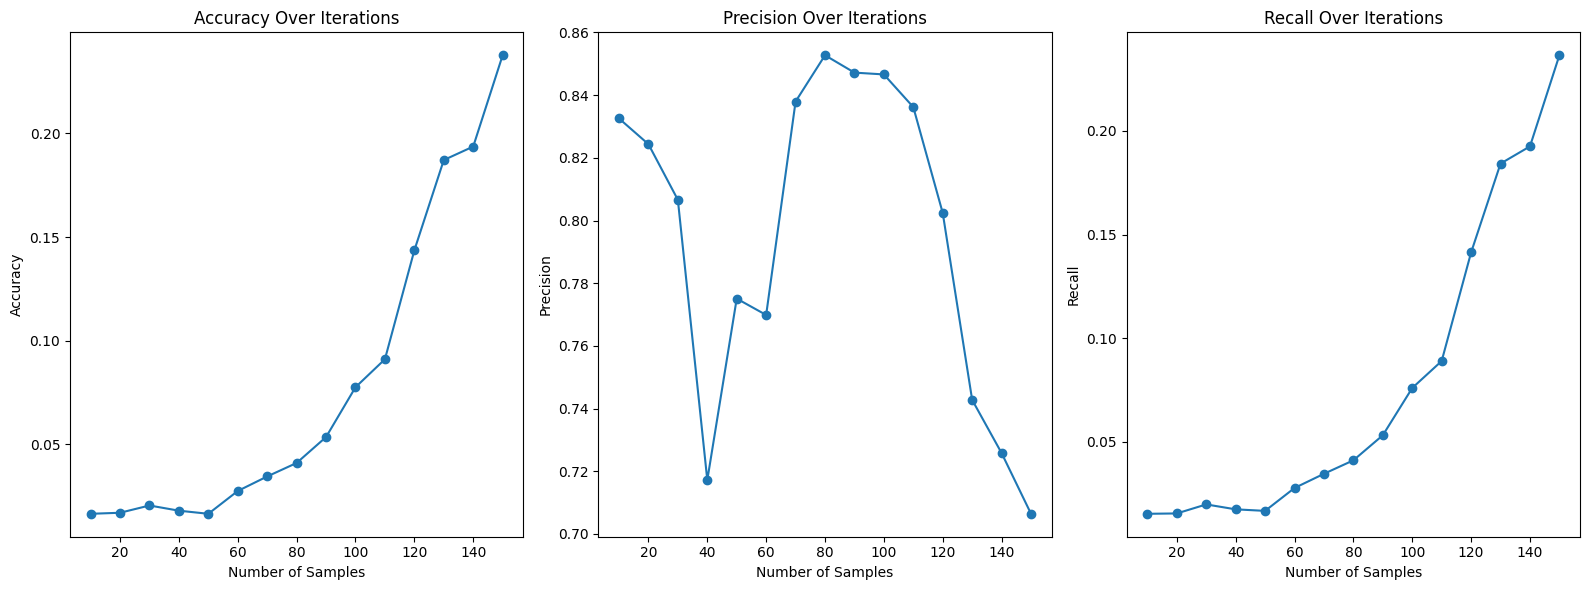

In [27]:
# Plot the metrics
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.plot(x_labels, accuracy_list, marker='o')
plt.title('Accuracy Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(x_labels, precision_list, marker='o')
plt.title('Precision Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Precision')

plt.subplot(1, 3, 3)
plt.plot(x_labels, recall_list, marker='o')
plt.title('Recall Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()

In [28]:
predictions = trainer.predict(test_dataloader)
predicted_labels = predictions.predictions.argmax(axis=1)
accuracy = accuracy_score(test_df['label'].to_list(),predicted_labels)
print('accuracy {}% '.format(np.round(accuracy * 100)))


  0%|          | 0/100 [00:00<?, ?it/s]

accuracy 24.0% 


In [29]:
bert_pred_df = pd.DataFrame({'Bert_Pred' : predicted_labels, 'Label' : test_df['label'].to_list() })

In [30]:
bert_pred_df.to_csv('Craigslist_Bert_Pred.csv',index=False)

In [31]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix

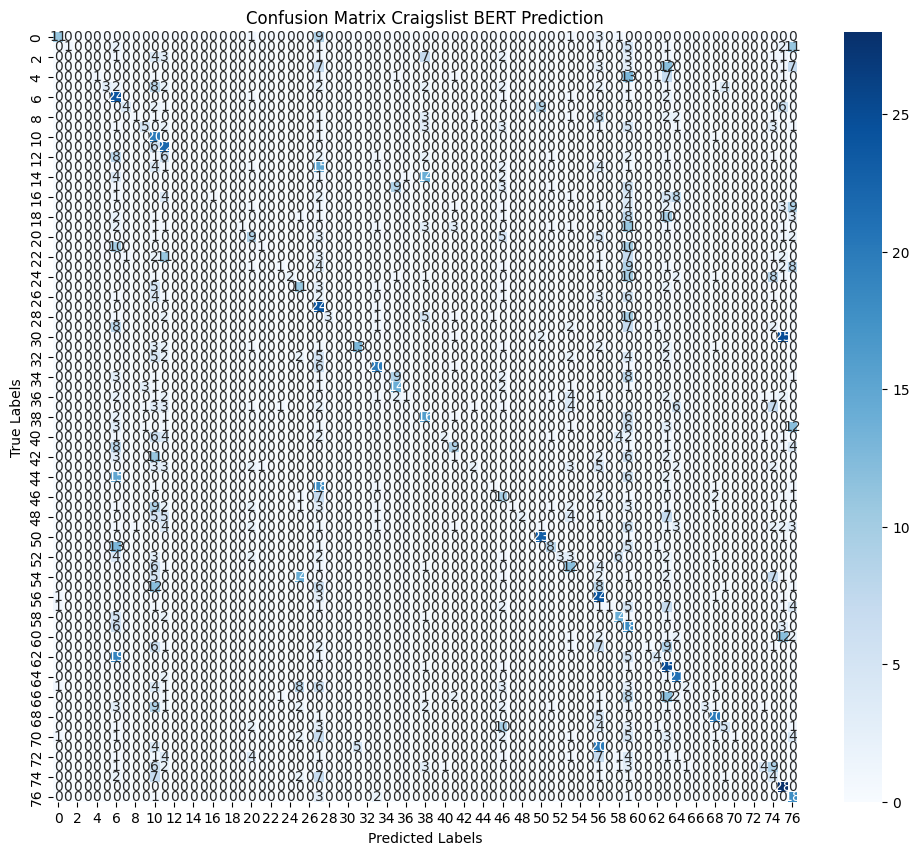

In [32]:
# Compute the confusion matrix
cm = confusion_matrix(test_df['label'].to_list(),predicted_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Craigslist BERT Prediction')
plt.show()

#  Craigslist label accuracies

In [33]:
import csv

# Combine the lists into a list of tuples
data = list(zip(x_labels, accuracy_list, precision_list, recall_list, loss_list))

# Specify the file name
csv_file_name = "Crag_Label_Accuracies.csv.csv"

# Write the data to a CSV file
with open(csv_file_name, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    
    csv_writer.writerow(['Labels', 'accuracy', 'precision', 'recall', 'loss'])
    
    # Write the data
    csv_writer.writerows(data)

print(f"CSV file '{csv_file_name}' has been created.")

CSV file 'Crag_Label_Accuracies.csv.csv' has been created.
